In [1]:
!pip install ../../OSAR-keras/.

Processing /mnt/c/Users/ustyu/OneDrive/Projects/OSAR-keras
  Preparing metadata (setup.py) ... done
  Created wheel for OSAR-nightly: filename=OSAR_nightly-0.1.17.dev20220326-cp39-cp39-linux_x86_64.whl size=68441 sha256=7695709c11351c70f92bb924c11a58cf891d5174f965582503ea5f9c4043cb66
  Stored in directory: /home/constantine/.cache/pip/wheels/b0/55/4a/1bb4852a26744ba9735d506993c618d1ab7be56275314d8ea7
Successfully built OSAR-nightly
  Attempting uninstall: OSAR-nightly
    Found existing installation: OSAR-nightly 0.1.17.dev20220326
    Uninstalling OSAR-nightly-0.1.17.dev20220326:
      Successfully uninstalled OSAR-nightly-0.1.17.dev20220326


In [2]:
from __future__ import absolute_import, division, print_function

import os
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import tempfile
import reverb

import tensorflow as tf

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.environments import suite_pybullet
from tf_agents.metrics import py_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.train import actor
from tf_agents.train import learner
from tf_agents.train import triggers
from tf_agents.train.utils import spec_utils
from tf_agents.train.utils import strategy_utils
from tf_agents.train.utils import train_utils
from tf_agents.utils import common

tempdir = tempfile.gettempdir()
from OSAR import OSARQNetwork, Runner, DQNTrialAgent

print(tf.version.VERSION)

2022-03-26 20:40:22.150957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-26 20:40:22.184961: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-26 20:40:22.185396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


2.7.0


2022-03-26 20:40:22.186871: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-26 20:40:22.188010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-26 20:40:22.188512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-26 20:40:22.188940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [4]:
env_names = [
    'Alien-ram-v0',
#     'MontezumaRevenge-ram-v0',
#     'AirRaid-ram-v0',
#     'Solaris-ram-v0',
#     'Berzerk-ram-v0',
#     'Asteroids-ram-v0',
#     'Venture-ram-v0',
#     'Asteroids-ram-v0',
#     'BattleZone-ram-v0',
#     'Enduro-ram-v0',
#     'Tutankham-ram-v0',
#     'WizardOfWor-ram-v0',
]

In [5]:
env_name = "Alien-ram-v0" # @param {type:"string"}


# Use "num_iterations = 1e6" for better results (2 hrs)
# 1e5 is just so this doesn't take too long (1 hr)
num_iterations = 10000 # @param {type:"integer"}

initial_collect_steps = 1000 # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 1000 # @param {type:"integer"}

batch_size = 16 # @param {type:"integer"}

learning_rate = 1e-3  # @param {type:"number"}
log_interval = 20  # @param {type:"integer"}
memory_len = 3 # @param {type: "integer"}
n_turns = 3 # @param {type: "integer"}
num_atoms = 51  # @param {type:"integer"}
q_value = 10  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}
boltzmann_temperature = 10e-5 # @param {type:"float"}
epsilon_greedy = None # @param {type:"float"}
conv_type = '1d' # @param {type:"str"}

log_interval = 100 # @param {type:"integer"}

num_eval_episodes = 20 # @param {type:"integer"}
eval_interval = 1000 # @param {type:"integer"}

policy_save_interval = 1000 # @param {type:"integer"}

fc_layer_params = (10, 10)

num_iterations = 10000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 1000  # @param {type:"integer"}



A.L.E: Arcade Learning Environment (version +978d2ce)
[Powered by Stella]


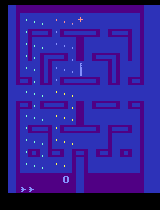

In [6]:
env = suite_pybullet.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

In [7]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(128,), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=17)


In [8]:
collect_env = suite_pybullet.load(env_name)
eval_env = suite_pybullet.load(env_name)

In [9]:
observation_spec, action_spec, time_step_spec = (
    spec_utils.get_tensor_specs(collect_env))

In [10]:
q_net = OSARQNetwork(
        observation_spec,
        action_spec,
        memory_len,
        n_turns,
        fc_layer_params=fc_layer_params,
        conv_type=conv_type,
        )

train_step = train_utils.create_train_step()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

tf_agent = DQNTrialAgent(
        time_step_spec,
        action_spec,
        network=q_net,
        optimizer=optimizer,
        td_errors_loss_fn=common.element_wise_squared_loss,
        boltzmann_temperature=boltzmann_temperature,
        epsilon_greedy=epsilon_greedy,
        debug_summaries=True,
        train_step_counter = train_step,
        summarize_grads_and_vars=True,
    )
    
tf_agent.initialize()

2022-03-26 20:40:24.855831: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-03-26 20:40:25.838545: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-03-26 20:40:26.949229: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Instructions for updating:
Do not call `graph_parents`.


In [11]:
rate_limiter=reverb.rate_limiters.SampleToInsertRatio(samples_per_insert=3.0, min_size_to_sample=3, error_buffer=3.0)

In [12]:
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1))

reverb_server = reverb.Server([table])

[reverb/cc/platform/tfrecord_checkpointer.cc:150]  Initializing TFRecordCheckpointer in /tmp/tmpp3oh9odp.
[reverb/cc/platform/tfrecord_checkpointer.cc:386] Loading latest checkpoint from /tmp/tmpp3oh9odp
[reverb/cc/platform/default/server.cc:71] Started replay server on port 15345


In [13]:
reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    sequence_length=2,
    table_name=table_name,
    local_server=reverb_server)

In [14]:
dataset = reverb_replay.as_dataset(
      sample_batch_size=batch_size, num_steps=2).prefetch(50)
experience_dataset_fn = lambda: dataset

In [15]:
tf_eval_policy = tf_agent.policy
eval_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_eval_policy, use_tf_function=True)

In [16]:
tf_collect_policy = tf_agent.collect_policy
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_collect_policy, use_tf_function=True)

In [17]:
random_policy = random_py_policy.RandomPyPolicy(
  collect_env.time_step_spec(), collect_env.action_spec())

In [18]:
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  reverb_replay.py_client,
  table_name,
  sequence_length=2,
  stride_length=1)

In [19]:
initial_collect_actor = actor.Actor(
  collect_env,
  random_policy,
  train_step,
  steps_per_run=initial_collect_steps,
  observers=[rb_observer])
initial_collect_actor.run()

In [20]:
env_step_metric = py_metrics.EnvironmentSteps()
collect_actor = actor.Actor(
  collect_env,
  collect_policy,
  train_step,
  steps_per_run=1,
  metrics=actor.collect_metrics(10),
  summary_dir=os.path.join(tempdir, learner.TRAIN_DIR),
  observers=[rb_observer, env_step_metric])
print(f'Saving to `{os.path.join(tempdir, learner.TRAIN_DIR)}`')

Saving to `/tmp/train`


In [21]:
eval_actor = actor.Actor(
  eval_env,
  eval_policy,
  train_step,
  episodes_per_run=num_eval_episodes,
  metrics=actor.eval_metrics(num_eval_episodes),
  summary_dir=os.path.join(tempdir, 'eval'),
)

In [22]:
saved_model_dir = os.path.join(tempdir, learner.POLICY_SAVED_MODEL_DIR)

# Triggers to save the agent's policy checkpoints.
learning_triggers = [
    triggers.PolicySavedModelTrigger(
        saved_model_dir,
        tf_agent,
        train_step,
        interval=policy_save_interval),
    triggers.StepPerSecondLogTrigger(train_step, interval=1000),
]

agent_learner = learner.Learner(
  tempdir,
  train_step,
  tf_agent,
  experience_dataset_fn,
  triggers=learning_triggers,
  strategy=None)

2022-03-26 20:40:30.208323: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
rename to distribute_datasets_from_function


/tmp/__autograph_generated_filehsl5n2uv.py:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  retval_ = ag__.and_(lambda : ag__.ld(state) is not None, lambda : ag__.and_(lambda : ag__.ld(state) is not (), lambda : ag__.ld(state) is not []))
/tmp/__autograph_generated_file50zufrmd.py:86: SyntaxWarning: "is" with a literal. Did you mean "=="?
  ag__.if_stmt(ag__.not_(ag__.or_(lambda : ag__.ld(policy_state) is None, lambda : ag__.or_(lambda : ag__.ld(policy_state) is (), lambda : ag__.ld(policy_state) is []))), if_body_2, else_body_2, get_state_2, set_state_2, (), 0)
/tmp/__autograph_generated_file7185mwac.py:74: SyntaxWarning: "is" with a literal. Did you mean "=="?
  ag__.if_stmt(ag__.ld(policy_state) is (), if_body_2, else_body_2, get_state_2, set_state_2, ('do_return', 'retval_'), 2)


In [23]:
def get_eval_metrics():
    eval_actor.run()
    results = {}
    for metric in eval_actor.metrics:
        results[metric.name] = metric.result()
    return results

metrics = get_eval_metrics()

In [24]:
def log_eval_metrics(step, metrics):
  eval_results = (', ').join(
      '{} = {:.6f}'.format(name, result) for name, result in metrics.items())
  print('step = {0}: {1}'.format(step, eval_results))

log_eval_metrics(0, metrics)

step = 0: AverageReturn = 174.000000, AverageEpisodeLength = 878.049988


In [25]:
try:
    %%time
except:
    pass

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = get_eval_metrics()["AverageReturn"]
returns = [avg_return]

for _ in range(num_iterations):
    # Training.
    collect_actor.run()
    loss_info = agent_learner.run(iterations=1)

    # Evaluating.
    step = agent_learner.train_step_numpy

    if eval_interval and step % eval_interval == 0:
        metrics = get_eval_metrics()
        log_eval_metrics(step, metrics)
        returns.append(metrics["AverageReturn"])

    if log_interval and step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, loss_info.loss.numpy()))

rb_observer.close()
reverb_server.stop()

[reverb/cc/client.cc:163] Sampler and server are owned by the same process (3459) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (3459) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (3459) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (3459) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (3459) so Table uniform_table is accessed directly without gRPC.


step = 100: loss = 0.2948237359523773
step = 200: loss = 0.0701318010687828
step = 300: loss = 0.015045980922877789
step = 400: loss = 0.0030048738699406385
step = 500: loss = 0.0005548637709580362
step = 600: loss = 9.1041591076646e-05
step = 700: loss = 1.2809778127120808e-05
step = 800: loss = 1.5181927892626845e-06
step = 900: loss = 1.5084953020050307e-07
step = 1000: AverageReturn = 166.000000, AverageEpisodeLength = 917.349976
step = 1000: loss = 1.2662928483564428e-08
step = 1100: loss = 9.044500703936365e-10
step = 1200: loss = 5.455993989933461e-11
step = 1300: loss = 6.825860189574318e-12
step = 1400: loss = 1.7949624263064595e-13
step = 1500: loss = 3.468903766665199e-12
step = 1600: loss = 1.0763983454564752e-11
step = 1700: loss = 6.1208468848938935e-12
step = 1800: loss = 3.063479677504593e-16
step = 1900: loss = 4.693301997038546e-11
step = 2000: AverageReturn = 164.000000, AverageEpisodeLength = 864.650024
step = 2000: loss = 4.067740588808988e-11
step = 2100: loss = 9

In [ ]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim()

In [ ]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

In [ ]:
num_episodes = 3
video_filename = 'sac_cc_minitaur.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_env.render())
    while not time_step.is_last():
      action_step = eval_actor.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_env.render())

embed_mp4(video_filename)